In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import matrixprofile as mp

def mprofile(ts):
    profile = mp.compute(ts, windows=48)
    figures = mp.visualize(profile)
    ax = plt.gca()
    ax.set_title(f'Matrix profile, 1 day window')

In [2]:
data = pd.read_csv('data.csv').to_numpy()

In [3]:
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [4]:
train_length = round(len(data) * 0.8)

In [5]:
train_data = torch.tensor(data[:train_length], dtype=torch.float32)
test_data = torch.tensor(data[train_length:], dtype=torch.float32)
all_data = torch.tensor(data, dtype=torch.float32)

In [6]:
train_loader = DataLoader(TensorDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=16, shuffle=False)
all_loader = DataLoader(TensorDataset(all_data), batch_size=16, shuffle=True)

In [7]:
# Сверточный автокодировщик
class ConvAutoencoder(nn.Module):
    def __init__(self, bottleneck_size):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, stride=2),  # (B, 8, 743) o1
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2),  # (B, 16, 371) o1
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2),  # (B, 32, 185) o1
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2),  # (B, 64, 92) o1
            nn.Flatten(),
            nn.Linear(64 * 92, bottleneck_size)
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 64 * 92),
            nn.Unflatten(1, (64, 92)),
            nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2),  # (B, 32, 185)
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2),  # (B, 16, 371)
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2),  # (B, 8, 743)
            nn.ReLU(),
            nn.ConvTranspose1d(8, 1, kernel_size=3, stride=2, output_padding=1),  # (B, 1, 1488)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = ConvAutoencoder(bottleneck_size=48).to(device)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [11]:
all_train_losses = []
train_losses = []
test_losses = []

In [14]:
epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in train_loader:
        batch = batch[0].unsqueeze(1).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_train_losses.append(loss.item())
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
    train_losses.append(avg_loss)
    
    model.eval()
    avg_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].unsqueeze(1).to(device)
            preds = model(batch)
            loss = criterion(preds, batch)
            
            avg_test_loss += loss.item()
    avg_test_loss /= len(test_loader)
    test_losses.append(avg_test_loss)
    print(f'Test Loss: {avg_test_loss:.4f}')

Epoch 1, Loss: 0.2848
Test Loss: 0.3265
Epoch 2, Loss: 0.2853
Test Loss: 0.3267
Epoch 3, Loss: 0.2826
Test Loss: 0.3271
Epoch 4, Loss: 0.2810
Test Loss: 0.3276
Epoch 5, Loss: 0.2805
Test Loss: 0.3276
Epoch 6, Loss: 0.2794
Test Loss: 0.3285
Epoch 7, Loss: 0.2777
Test Loss: 0.3286
Epoch 8, Loss: 0.2782
Test Loss: 0.3310
Epoch 9, Loss: 0.2766
Test Loss: 0.3293
Epoch 10, Loss: 0.2758
Test Loss: 0.3308
Epoch 11, Loss: 0.2735
Test Loss: 0.3307
Epoch 12, Loss: 0.2732
Test Loss: 0.3304
Epoch 13, Loss: 0.2718
Test Loss: 0.3312
Epoch 14, Loss: 0.2714
Test Loss: 0.3313
Epoch 15, Loss: 0.2701
Test Loss: 0.3319
Epoch 16, Loss: 0.2690
Test Loss: 0.3321
Epoch 17, Loss: 0.2684
Test Loss: 0.3330
Epoch 18, Loss: 0.2672
Test Loss: 0.3338
Epoch 19, Loss: 0.2661
Test Loss: 0.3341
Epoch 20, Loss: 0.2660
Test Loss: 0.3351
Epoch 21, Loss: 0.2633
Test Loss: 0.3352
Epoch 22, Loss: 0.2622
Test Loss: 0.3350
Epoch 23, Loss: 0.2617
Test Loss: 0.3363
Epoch 24, Loss: 0.2601
Test Loss: 0.3372
Epoch 25, Loss: 0.2601
Te

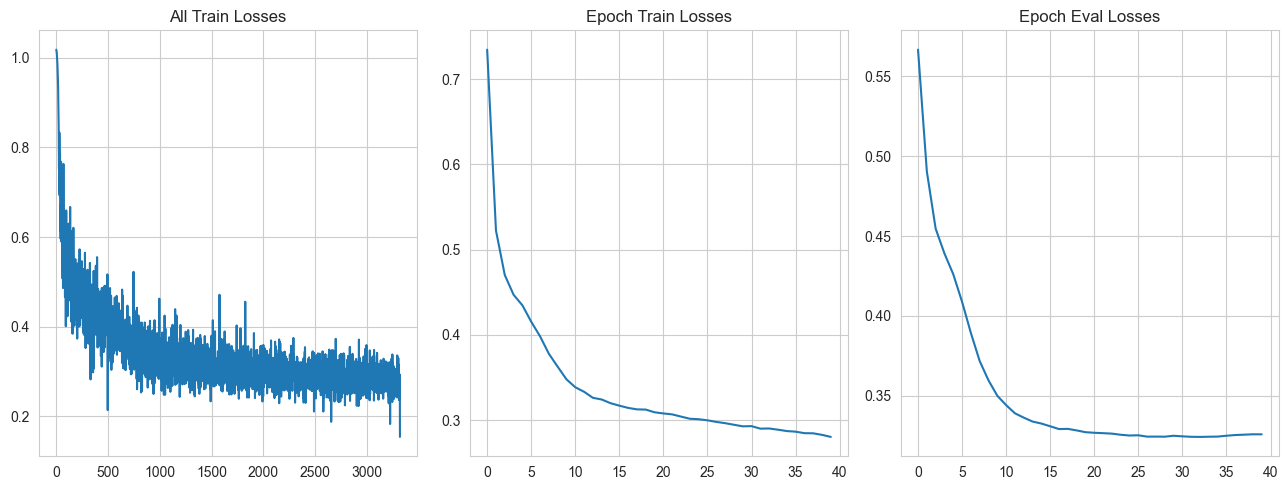

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(all_train_losses)
axes[0].set_title('All Train Losses')
axes[1].plot(train_losses)
axes[1].set_title('Epoch Train Losses')
axes[2].plot(test_losses)
axes[2].set_title('Epoch Eval Losses')
plt.tight_layout()
plt.show()

In [15]:
model = ConvAutoencoder(bottleneck_size=48).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in all_loader:
        batch = batch[0].unsqueeze(1).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 1.1375
Epoch 2, Loss: 0.7102
Epoch 3, Loss: 0.6413
Epoch 4, Loss: 0.5888
Epoch 5, Loss: 0.5650
Epoch 6, Loss: 0.5470
Epoch 7, Loss: 0.5285
Epoch 8, Loss: 0.5027
Epoch 9, Loss: 0.4774
Epoch 10, Loss: 0.4568
Epoch 11, Loss: 0.4408
Epoch 12, Loss: 0.4276
Epoch 13, Loss: 0.4191
Epoch 14, Loss: 0.4121
Epoch 15, Loss: 0.4073
Epoch 16, Loss: 0.4034
Epoch 17, Loss: 0.4003
Epoch 18, Loss: 0.3976
Epoch 19, Loss: 0.3948
Epoch 20, Loss: 0.3930
Epoch 21, Loss: 0.3906
Epoch 22, Loss: 0.3890
Epoch 23, Loss: 0.3865
Epoch 24, Loss: 0.3845
Epoch 25, Loss: 0.3830


In [53]:
errors = []
encoded = []
reconstructed = []
with torch.no_grad():
    for sample in all_data:
        inputs = sample.view(1, 1, -1).to(device)
        res = model(inputs).cpu().detach().flatten()
        reconstruction_error = criterion(res, sample)
        errors.append(reconstruction_error.numpy())
        
        features = model.encoder(inputs).view(-1)
        encoded.append(features.cpu().detach().numpy())
        
        reconstructed.append(res.view(-1).cpu().detach().numpy())

errors = np.array(errors)
encoded = np.array(encoded)
reconstructed = np.array(reconstructed)

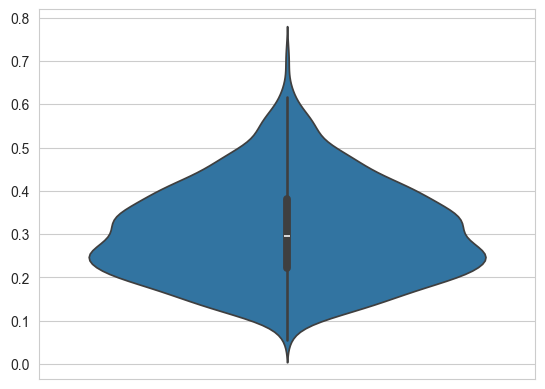

In [54]:
sns.violinplot(errors)
plt.show()

In [93]:
np.quantile(errors, 0.99)

0.5846481758356089

In [55]:
np.column_stack((np.argsort(-errors), -np.sort(-errors)))

array([[1.22500000e+03, 7.29207695e-01],
       [2.80000000e+01, 7.00539887e-01],
       [9.08000000e+02, 6.95356250e-01],
       ...,
       [1.50500000e+03, 6.69705272e-02],
       [1.09000000e+02, 6.23701550e-02],
       [2.23000000e+02, 5.54197766e-02]])

In [26]:
import matrixprofile as mp

def mprofile(ts):
    profile = mp.compute(ts, windows=48)
    figures = mp.visualize(profile)
    ax = plt.gca()
    ax.set_title(f'Matrix profile, 1 day window')

In [94]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()

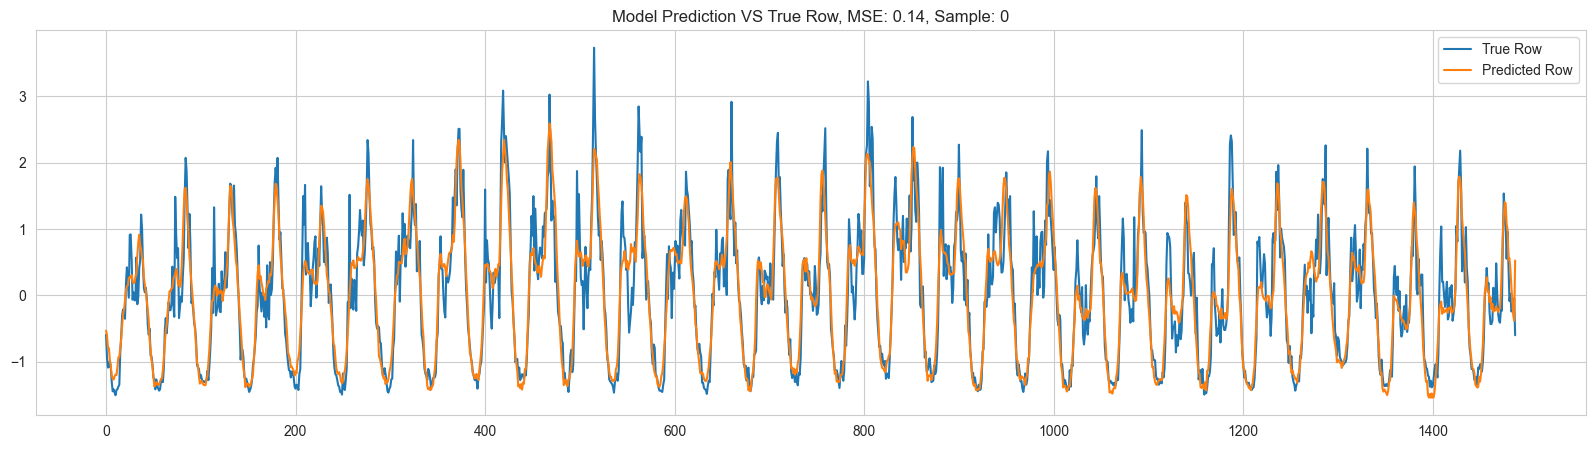

In [95]:
plot_sample(0)

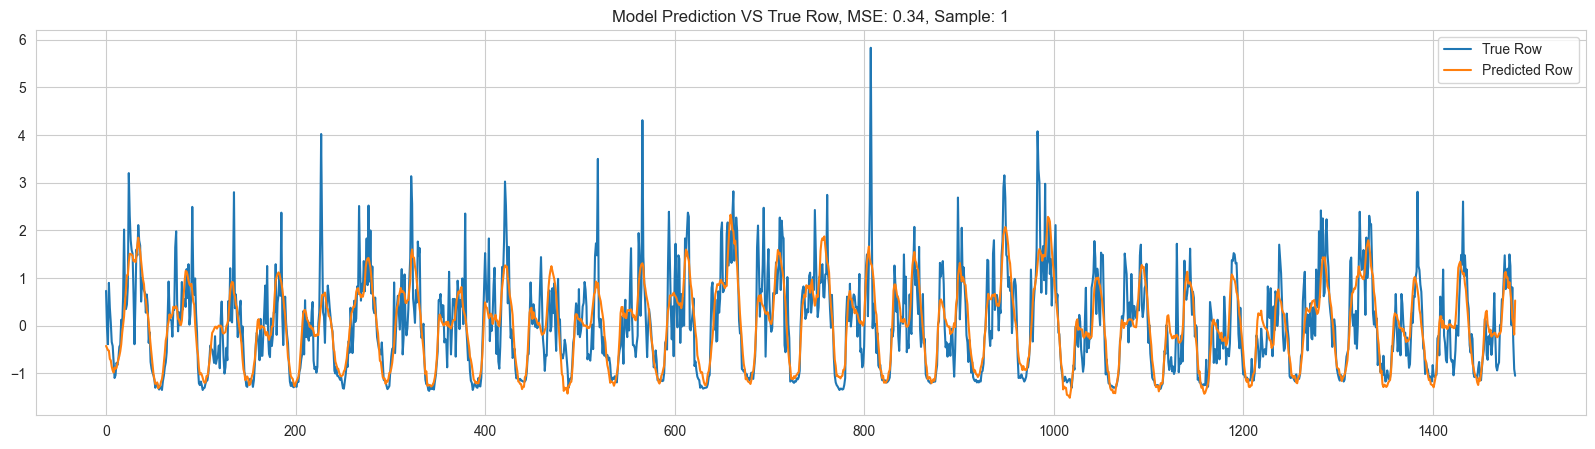

In [96]:
plot_sample(1)

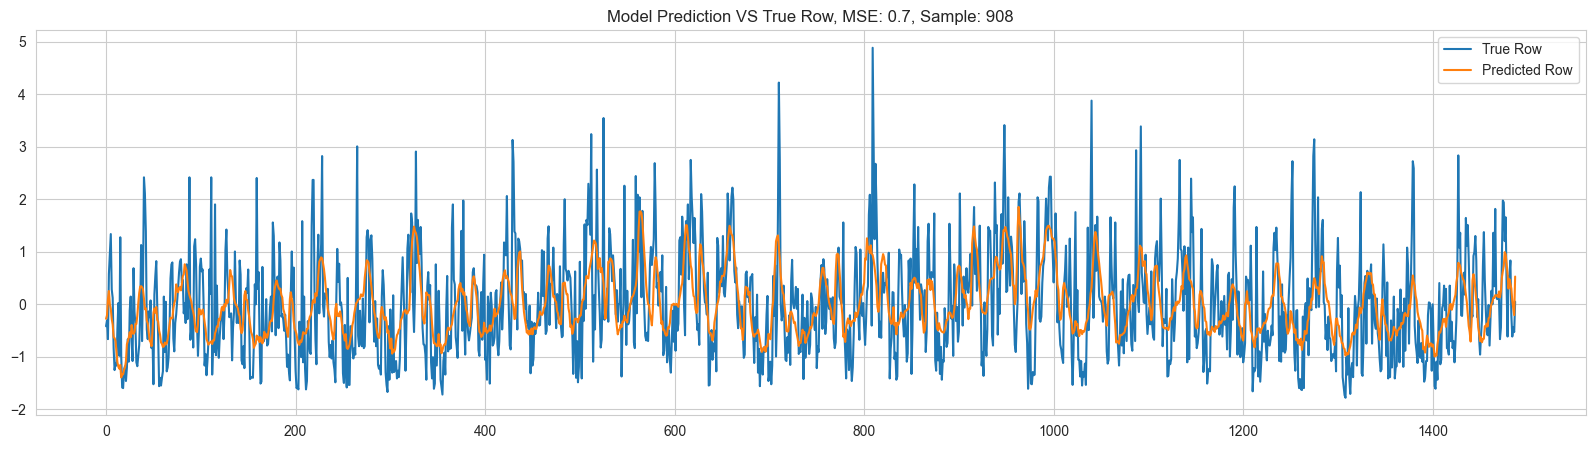

In [98]:
plot_sample(908)

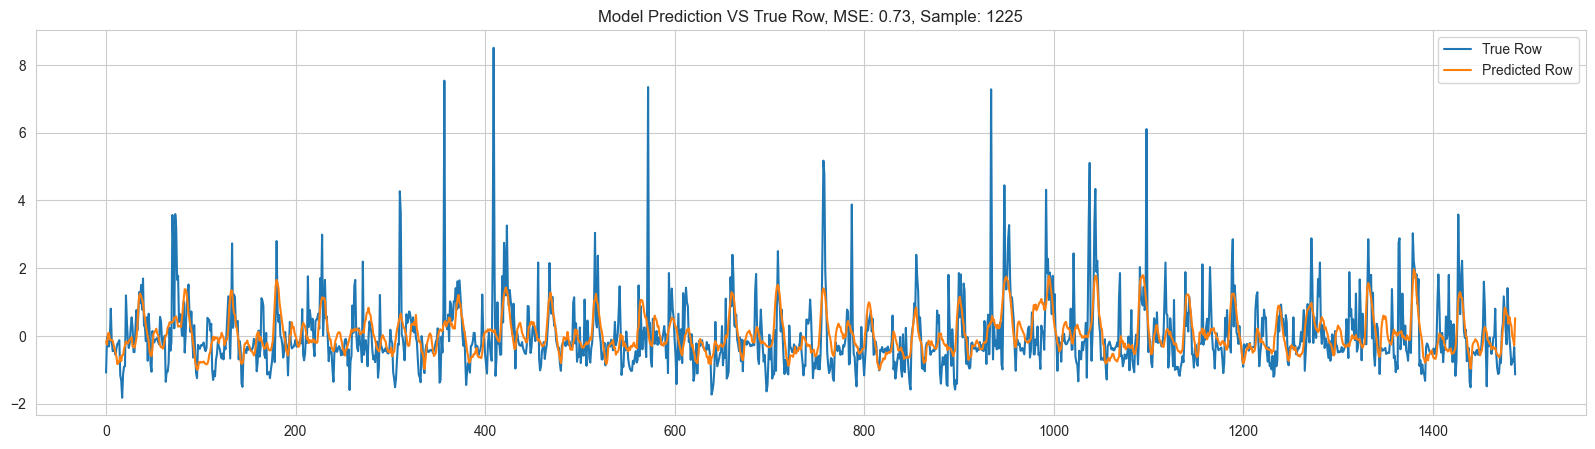

In [99]:
plot_sample(1225)

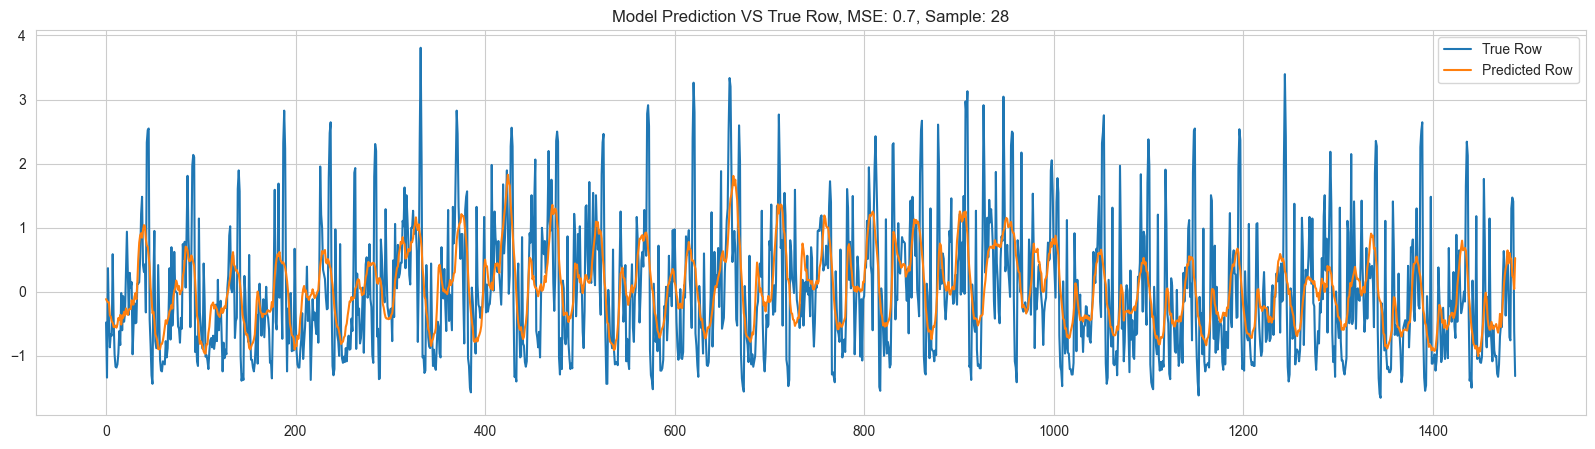

In [100]:
plot_sample(28)

In [38]:
# torch.save(model.state_dict(), 'models/convautoencoder_rec.pt')

In [101]:
encoded

array([[ -9.605018 ,  -6.6756473,   9.848192 , ...,  12.266168 ,
         -1.5239463,  13.228267 ],
       [ -7.197324 ,  -7.427423 ,   9.715403 , ...,   3.5480309,
         -7.1637435,  10.095469 ],
       [-12.94872  ,  -2.6620922,  16.347847 , ...,  10.263311 ,
         -4.94312  ,  21.079378 ],
       ...,
       [-18.899464 ,  -4.4049296,   9.224385 , ...,   8.275709 ,
          5.4280534,   7.4963903],
       [ -6.745224 ,  -6.729489 ,   7.6658597, ...,   3.5675223,
         -8.521994 ,  -4.4296074],
       [ -1.2032337,  -1.5744377,  10.140322 , ...,  10.531704 ,
        -13.976534 ,   5.7490377]], dtype=float32)

In [109]:
encoded_norm = (encoded - encoded.mean(axis=0)) / encoded.std(axis=0)

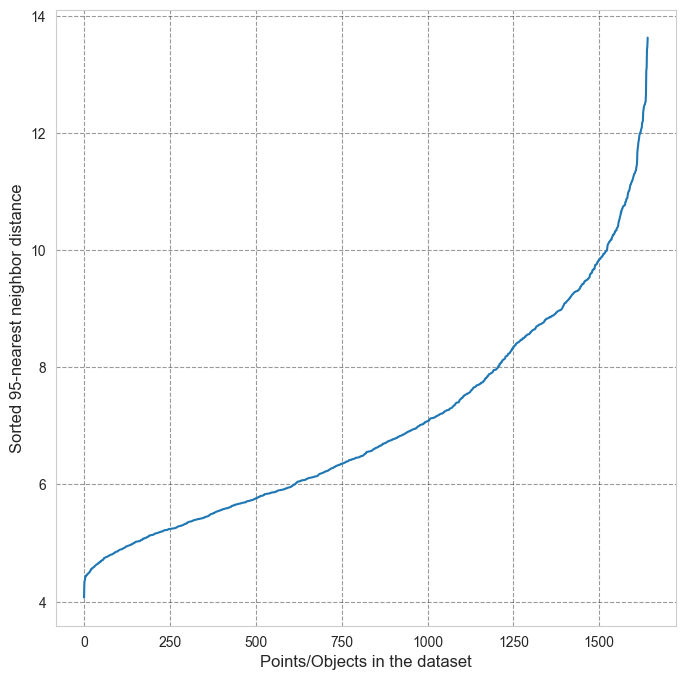

In [111]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_norm.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_norm, k=k)

In [137]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=11, min_samples=30)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_norm)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]
anomalies_indices

array([  56,  146,  528,  584,  692,  704,  950,  998, 1119, 1486],
      dtype=int64)

In [127]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded)
explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.24063122, 0.1106789 ], dtype=float32)

In [128]:
encoded_pca

array([[-15.4431925,  16.551218 ],
       [-18.622623 ,   6.2696023],
       [-17.606638 ,  11.360582 ],
       ...,
       [ 32.364475 ,  37.78713  ],
       [  5.0705338,   2.1012857],
       [ -3.5886557,   2.7009115]], dtype=float32)

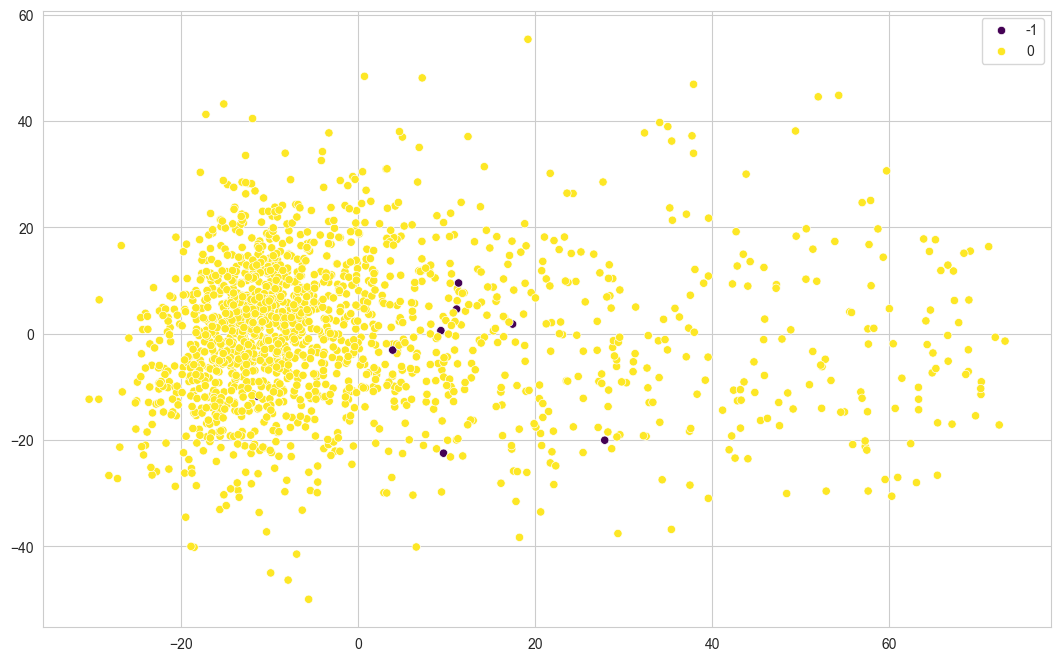

In [129]:
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=clusters, palette='viridis')
plt.gcf().set_size_inches(13, 8)
plt.show()

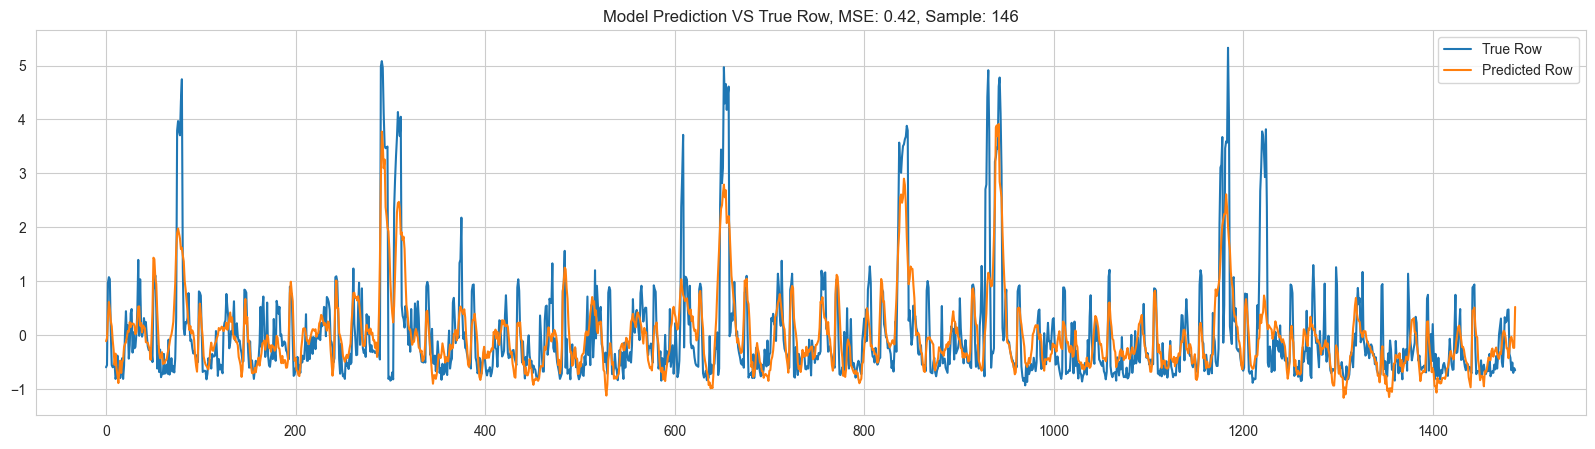

In [132]:
plot_sample(146)

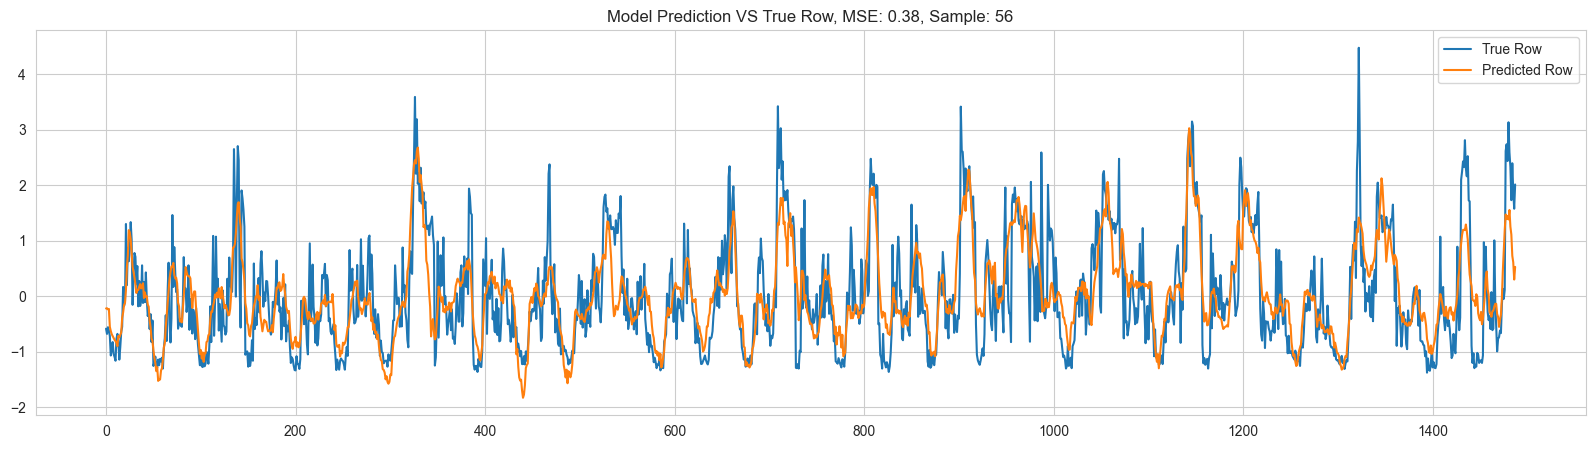

In [131]:
plot_sample(56)

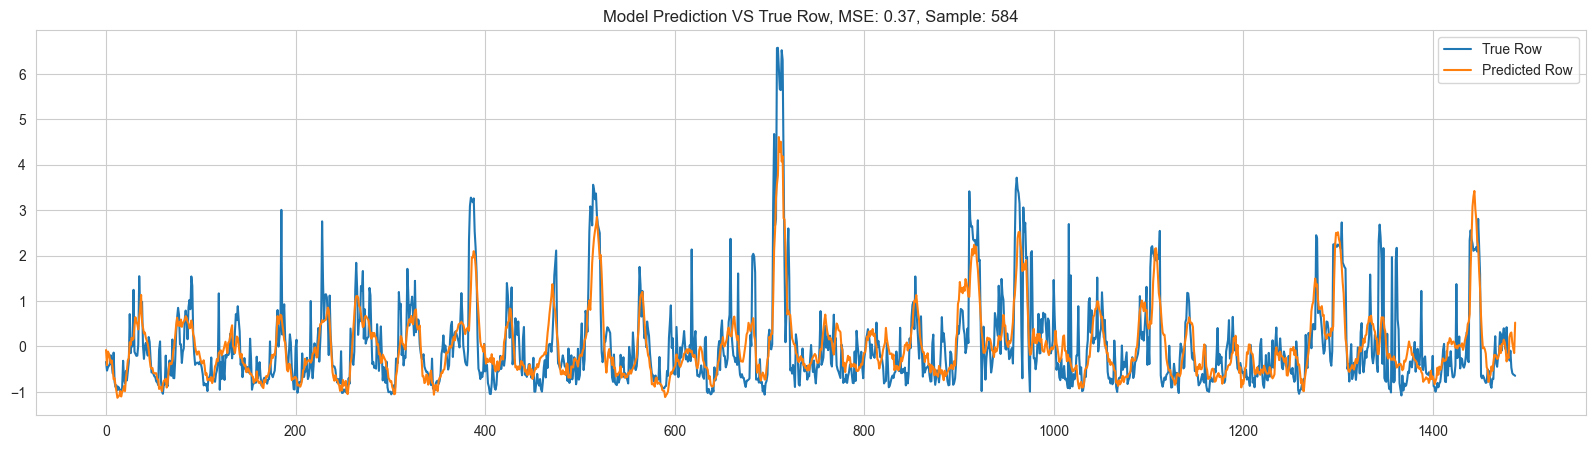

In [133]:
plot_sample(584)